# Bohndesliga Table Style

Bohndesliga is a german online broadbast by [Rocket Beans TV](https://rocketbeans.tv/). In their show they discuss the recent games of the Bundesliga (in german). They have created a nice visual style to show the Bundesliga table that we are going to recreate with plottable (with a few details adjusted).

You can view an example of the table we are going to recreate at this [timestamped video](https://youtu.be/VhLTS8J1N_M?t=5578).

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from plottable import ColDef, Table
from plottable.plots import image

## Getting the data

In [2]:
FIVETHIRTYEIGHT_URLS = {
    "SPI_MATCHES": "https://projects.fivethirtyeight.com/soccer-api/club/spi_matches.csv",
    "SPI_MATCHES_LATEST": "https://projects.fivethirtyeight.com/soccer-api/club/spi_matches_latest.csv",
}

df = pd.read_csv(FIVETHIRTYEIGHT_URLS["SPI_MATCHES_LATEST"])

In [3]:
bl = df.loc[df.league == "German Bundesliga"].dropna()

## Data Processing

In [4]:
def add_points(df: pd.DataFrame) -> pd.DataFrame:
    df["pts_home"] = np.where(
        df["score1"] > df["score2"], 3, np.where(df["score1"] == df["score2"], 1, 0)
    )
    df["pts_away"] = np.where(
        df["score1"] < df["score2"], 3, np.where(df["score1"] == df["score2"], 1, 0)
    )
    
    return df


def get_wins_draws_losses(games: pd.DataFrame) -> pd.DataFrame:
    return (
        games.rename({"pts_home": "pts", "team1": "team"}, axis=1)
        .groupby("team")["pts"]
        .value_counts()
        .add(
            games.rename({"pts_away": "pts", "team2": "team"}, axis=1)
            .groupby("team")["pts"]
            .value_counts(),
            fill_value=0,
        )
        .astype(int)
        .rename("count")
        .reset_index(level=1)
        .pivot(columns="pts", values="count")
        .rename({0: "L", 1: "D", 3: "W"}, axis=1)[["W", "D", "L"]]
    )

In [5]:
bl = add_points(bl)

In [6]:
perform = (
    bl.groupby("team1")[[
        "pts_home",
        "score1",
        "score2",
        "xg1",
        "xg2",
    ]]
    .sum()
    .set_axis(
        [
            "pts",
            "gf",
            "ga",
            "xgf",
            "xga",
        ],
        axis=1,
    )
    .add(
        bl.groupby("team2")[[
            "pts_away",
            "score2",
            "score1",
            "xg2",
            "xg1",
        ]]
        .sum()
        .set_axis(
            [
                "pts",
                "gf",
                "ga",
                "xgf",
                "xga",
            ],
            axis=1,
        )
    )
)

perform.index.name = "team"

perform["gd"] = perform["gf"] - perform["ga"]

perform = perform[
    [
        "pts",
        "gd",
        "gf",
        "ga",
        "xgf",
        "xga",
    ]
]

perform["games"] = bl.groupby("team1").size().add(bl.groupby("team2").size())

In [7]:
wins_draws_losses = get_wins_draws_losses(bl)
perform = pd.concat([perform, wins_draws_losses], axis=1)

In [8]:
perform

,pts,gd,gf,ga,xgf,xga,games,W,D,L
team,,,,,,,,,,
1. FC Union Berlin,26,7.0,21.0,14.0,12.12,13.89,13,8,2,3
Bayer Leverkusen,12,-4.0,21.0,25.0,20.14,21.51,13,3,3,7
Bayern Munich,31,34.0,47.0,13.0,39.50,15.53,14,9,4,1
Borussia Dortmund,25,6.0,23.0,17.0,22.70,16.51,14,8,1,5
Borussia Monchengladbach,19,2.0,24.0,22.0,22.41,22.14,14,5,4,5
Eintracht Frankfurt,23,6.0,27.0,21.0,21.27,16.80,13,7,2,4
FC Augsburg,14,-7.0,16.0,23.0,14.01,28.49,13,4,2,7
FC Cologne,17,-5.0,20.0,25.0,20.53,17.21,13,4,5,4
Hertha Berlin,11,-5.0,17.0,22.0,18.38,23.08,14,2,5,7


In [9]:
# mapping teamnames to logo paths

club_logo_path = Path("bundesliga_crests_22_23")
club_logo_files = list(club_logo_path.glob("*.png"))
club_logos_paths = {f.stem: f for f in club_logo_files}

In [10]:
perform = perform.reset_index()

# Add a column for crests
perform.insert(0, "crest", perform["team"])
perform["crest"] = perform["crest"].replace(club_logos_paths)

# sort by table standings
perform = perform.sort_values(by=["pts", "gd", "gf"], ascending=False)

for colname in ["gd", "gf", "ga"]:
    perform[colname] = perform[colname].astype("int32")

perform["goal_difference"] = perform["gf"].astype(str) + ":" + perform["ga"].astype(str)

perform["rank"] = list(range(1, 19))

## Building the Bohndesliga Table

In [11]:
row_colors = {
    "top4": "#2d3636",
    "top6": "#516362",
    "playoffs": "#8d9386",
    "relegation": "#c8ab8d",
    "even": "#627979",
    "odd": "#68817e",
}

bg_color = row_colors["odd"]
text_color = "#e0e8df"

table_cols = ["crest", "team", "games", "W", "D", "L", "goal_difference", "gd", "pts"]

In [12]:
perform[table_cols]

,crest,team,games,W,D,L,goal_difference,gd,pts
2,bundesliga_crests_22_23\Bayern Munich.png,Bayern Munich,14,9,4,1,47:13,34,31
11,bundesliga_crests_22_23\SC Freiburg.png,SC Freiburg,13,8,3,2,20:13,7,27
0,bundesliga_crests_22_23\1. FC Union Berlin.png,1. FC Union Berlin,13,8,2,3,21:14,7,26
3,bundesliga_crests_22_23\Borussia Dortmund.png,Borussia Dortmund,14,8,1,5,23:17,6,25
5,bundesliga_crests_22_23\Eintracht Frankfurt.png,Eintracht Frankfurt,13,7,2,4,27:21,6,23
10,bundesliga_crests_22_23\RB Leipzig.png,RB Leipzig,13,6,4,3,25:19,6,22
17,bundesliga_crests_22_23\Werder Bremen.png,Werder Bremen,14,6,3,5,24:25,-1,21
16,bundesliga_crests_22_23\VfL Wolfsburg.png,VfL Wolfsburg,14,5,5,4,22:19,3,20
4,bundesliga_crests_22_23\Borussia Monchengladba...,Borussia Monchengladbach,14,5,4,5,24:22,2,19
13,bundesliga_crests_22_23\TSG Hoffenheim.png,TSG Hoffenheim,13,5,3,5,19:16,3,18


### Setting up the ColumnDefinitions

With the ColumnDefinitions we we can adjust the tables style by supplying keywords such as `title`, `width`, `formatters` and `textprops`.

```{seealso}
You can view more details in the [Using ColumnDefinition Notebook](../notebooks/column_definition.ipynb).
```

In [13]:
table_col_defs = [
    ColDef("rank", width=0.5, title=""),
    ColDef("crest", width=0.35, plot_fn=image, title=""),
    ColDef("team", width=2.5, title="", textprops={"ha": "left"}),
    ColDef("games", width=0.5, title="Games"),
    ColDef("W", width=0.5),
    ColDef("D", width=0.5),
    ColDef("L", width=0.5),
    ColDef("goal_difference", title="Goals"),
    ColDef("gd", width=0.5, title="", formatter="{:+}"),
    ColDef("pts", border="left", title="Points"),
]

### Plotting the Table

```{seealso}
Here we use various keywords of `Table` to control its appearance. You can view more details in the [Styling a Table Notebook](../notebooks/column_definition.ipynb).
```

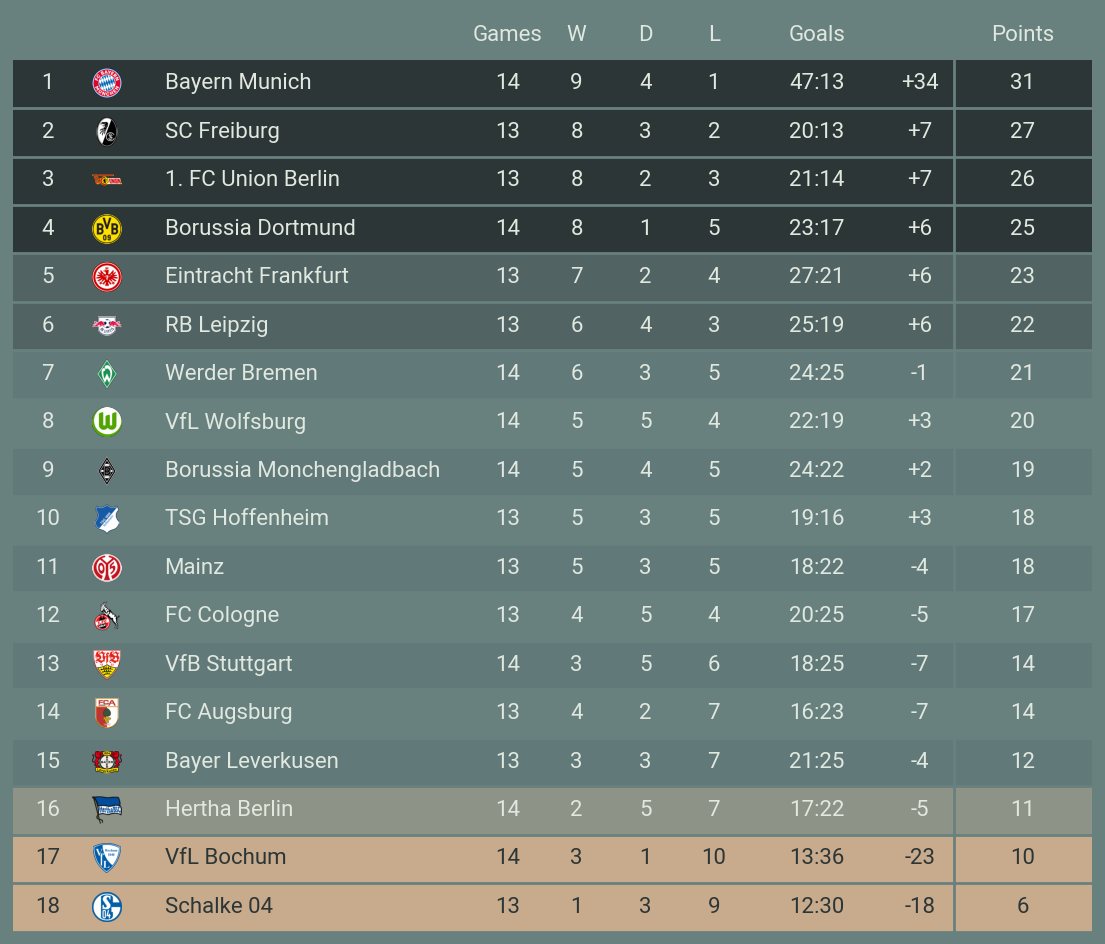

In [14]:
fig, ax = plt.subplots(figsize=(14, 12))

plt.rcParams["text.color"] = text_color
plt.rcParams["font.family"] = "Roboto"

fig.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

table = Table(
    perform,
    column_definitions=table_col_defs,
    row_dividers=True,
    col_label_divider=False,
    footer_divider=True,
    index_col="rank",
    columns=table_cols,
    even_row_color=row_colors["even"],
    footer_divider_kw={"color": bg_color, "lw": 2},
    row_divider_kw={"color": bg_color, "lw": 2},
    column_border_kw={"color": bg_color, "lw": 2},
    textprops={"fontsize": 16, "ha": "center", "fontname": "Roboto"},
)

for idx in [0, 1, 2, 3]:
    table.rows[idx].set_facecolor(row_colors["top4"])
    
for idx in [4, 5]:
    table.rows[idx].set_facecolor(row_colors["top6"])
    
table.rows[15].set_facecolor(row_colors["playoffs"])

for idx in [16, 17]:
    table.rows[idx].set_facecolor(row_colors["relegation"])
    table.rows[idx].set_fontcolor(row_colors["top4"])

    
fig.savefig(
    "images/bohndesliga_table_recreation.png",
    facecolor=fig.get_facecolor(),
    dpi=200,
)

Note on the slightly adjusted details:  
I chose to make the light text a little lighter than the original and used the background color of the top4 rows as the fontcolor for the bottom two rows because I think the higher contrast makes it a little bit easier to read.  
I also chose to stick to the light text on the background for the header row to keep this consistent.  
Finally I added a little clarity by adding titles to the points and goal difference columns. This also allowed me to not highlight the points additionally with a bold weight.